In [25]:
IRdisplay::display_html("
<style>
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}
body.rise-enabled div.inner_cell>div.input_area {
    font-size: 150%;
}

body.rise-enabled div.output_subarea.output_text.output_result {
    font-size: 150%;
}
body.rise-enabled div.output_subarea.output_text.output_stream.output_stdout {
  font-size: 150%;
}
</style>
")

In [2]:
library(tidyverse)
library(nycflights13)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.0     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


### Review
Assume every flight is full. The busiest travel day in terms of total # of passengers who departed is:

1. Jul. 3
1. Nov. 26
2. Nov. 27
3. Dec. 26
4. Dec. 27

In [51]:
flights %>% left_join(planes, by = 'tailnum') %>% group_by(month, day) %>% 
   summarize(num_pass = sum(seats, na.rm = T)) %>% ungroup %>% top_n(1) %>% print

Selecting by num_pass


# A tibble: 1 x 3
  month   day num_pass
  <int> <int>    <int>
1    11    27   118869


# Lecture 10: More on relational data; SQL
<div style="border: 1px double black; padding: 10px; margin: 10px">

**After today's lecture you will:**
* Understand how to [filter data using joins](#Filtering-joins)
* Know to execute basic [SQL commands](#SQL-Commands)
</div>


## Filtering joins

Filtering joins allow us to filter rows on one table based on their presence or absence in another table. We've already seen some examples of this on the problem sets:

In [53]:
top6 = count(flights, carrier) %>% top_n(6) %>% print
flights_top6 = filter(flights, carrier %in% top6$carrier) %>% print

Selecting by n


# A tibble: 6 x 2
  carrier     n
  <chr>   <int>
1 AA      32729
2 B6      54635
3 DL      48110
4 EV      54173
5 MQ      26397
6 UA      58665


What if we wanted to filter based on more than one variable? For example, based on busiest days of the year:

In [33]:
top6_days = count(flights, year, month, day) %>% top_n(6) %>% print

Selecting by n


# A tibble: 7 x 4
   year month   day     n
  <int> <int> <int> <int>
1  2013     7     8  1004
2  2013     7    10  1004
3  2013     7    11  1006
4  2013     7    18  1003
5  2013     7    25  1003
6  2013    11    27  1014
7  2013    12     2  1004


One option would be to construct a new string variable which we could then match using the same technique:

In [56]:
top6_days_ymd = unite(top6_days, ymd, year:day, sep="-") %>% print
flights_ymd = unite(flights, ymd, year:day, sep="-")
filter(flights_ymd, ymd %in% top6_days_ymd) %>% print

# A tibble: 7 x 2
  ymd            n
  <chr>      <int>
1 2013-7-8    1004
2 2013-7-10   1004
3 2013-7-11   1006
4 2013-7-18   1003
5 2013-7-25   1003
6 2013-11-27  1014
7 2013-12-2   1004


But this is cumbersome and will also be slow if you are matching to a large list of choices.

### Semi-join
A better option is to use the built-in command `semi_join`. `semi_join(x, y)` keeps all the observations in `x` that are also in `y`.
![semi join](http://r4ds.had.co.nz/diagrams/join-semi.png)

`semi_join()` takes the same `key=` options as the other join commands.

In [57]:
# All flights in 6 busiest days of year:
semi_join(flights, top6_days, key = c("year", "month", "day")) %>% print

Joining, by = c("year", "month", "day")


# A tibble: 7,038 x 19
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013    11    27       28           1930       298      129           2049
 2  2013    11    27      505            500         5      703            651
 3  2013    11    27      514            515        -1      743            808
 4  2013    11    27      535            540        -5      907            850
 5  2013    11    27      540            545        -5      815            835
 6  2013    11    27      551            600        -9      920            854
 7  2013    11    27      551            600        -9      918            849
 8  2013    11    27      554            600        -6      719            719
 9  2013    11    27      554            600        -6      707            717
10  2013    11    27      554            600        -6      907            846
# ... with 7,028 more rows, a

### Exercise
Of the 336,776 flights in `flights`, what % of them departed on one of the 20 busiest days of the year?

In [4]:
top20_days = count(flights, year, month, day) %>% top_n(20)
semi_join(flights, top20_days) %>% nrow / nrow(flights)

Selecting by n
Joining, by = c("year", "month", "day")


[1] 0.05952324

### Anti-join
The opposite of a semi-join is an anti-join:
![anti-join](http://r4ds.had.co.nz/diagrams/join-anti.png)

### Exercise
<table><tr><th>Beginner</th><th>Advanced</th></tr>
    <tr>
        <td>How many flights were on planes which are <i>not</i> found in the <code>planes</code> table?</td>
        <td>How many planes flew to destinations which are <i>not</i> found in the <code>airports</code> table?</td>
    </tr>
    </table>

In [8]:
anti_join(flights, planes, by = "tailnum") %>% nrow # beginner
left_join(flights, planes, by = "tailnum") %>% 
    anti_join(airports, by = c("dest" = "faa")) %>% nrow # advanced

[1] 52606

[1] 7602

Anti-joins are useful for finding mismatches in joins. Last lecture we saw that some 50k entries in `flights` have `tailnum`s that do not exist in the `planes` table. To find out more about these flights we could use an anti-join to select only those rows:

In [40]:
missing_planes = anti_join(flights, planes, by="tailnum") %>% 
                 filter(!is.na(tailnum)) %>% print

# A tibble: 50,094 x 19
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      558            600        -2      753            745
 2  2013     1     1      559            600        -1      941            910
 3  2013     1     1      600            600         0      837            825
 4  2013     1     1      602            605        -3      821            805
 5  2013     1     1      608            600         8      807            735
 6  2013     1     1      611            600        11      945            931
 7  2013     1     1      623            610        13      920            915
 8  2013     1     1      624            630        -6      840            830
 9  2013     1     1      628            630        -2     1137           1140
10  2013     1     1      629            630        -1      824            810
# ... with 50,084 more rows,

Do we see any pattern in this table that could explain the missing tail numbers?

In [82]:
missing_planes %>% sample_n(100) %>% print(width = Inf)

# A tibble: 100 x 19
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013    12     8     1353           1350         3     1701           1705
 2  2013    11    20      749            755        -6      901            910
 3  2013     4     8     1938           1945        -7     2225           2300
 4  2013    12     8       NA           1455        NA       NA           1655
 5  2013    11     5     1628           1635        -7     1752           1815
 6  2013     4     9     1428           1440       -12     1601           1630
 7  2013     4    25     1325           1300        25     1508           1435
 8  2013    10    17      557            600        -3     1121            905
 9  2013    12     4     1105           1115       -10     1425           1425
10  2013     6    20     1945           1950        -5     2101           2130
   arr_delay carrier flight tai

Interestingly, the top 5 most frequent `tailnum`s in the overall data are almost the same:

In [161]:
flights %>% drop_na(tailnum) %>% left_join(planes, by = "tailnum") %>% 
    count(tailnum, model) %>% top_n(5)

Selecting by n


  tailnum model  n  
1 N711MQ  G1159B 486
2 N713MQ  NA     483
3 N722MQ  NA     513
4 N723MQ  NA     507
5 N725MQ  NA     575

In [173]:
planes %>% filter(tailnum == "N711MQ")

  tailnum year type                    manufacturer         model  engines
1 N711MQ  1976 Fixed wing multi engine GULFSTREAM AEROSPACE G1159B 2      
  seats speed engine   
1 22    NA    Turbo-jet

The one plane that is represented is N711M. You can [look it up](https://flightaware.com/resources/registration/N711MQ) in an online database and find out it's a private jet. My guess is the others are private jets too.

### SQL Queries


(After last lecture several students contacted me and said they were interested in hearing more about SQL. Since we only spent the last five minutes of lecture talking about this, I have decided to cover this material in more detail.)



SQL stands for "Structured Query Language". Many large databases are stored in SQL format, and you will probably encounter one if you work on big data and/or at a large company. 

To introduce SQL we're going to use the `sqldf` package, which lets us run SQL queries on R tibbles/data frames. Also, to make things go faster, we'll operate on a subsetted version of flights which takes 1% of randomly sampled rows.

In [162]:
# install.packages("sqldf") if necessary
library(sqldf)
flights_sub <- slice(flights, seq(1, nrow(flights), length.out = 10000))
# This function takes the data.frame outputted from sqldf and converts it to a tibble
sqltbl <- function(...) sqldf(...) %>% tbl_df

### Selecting data from a table
The SQL syntax for selecting column(s) from a table is
```{sql}
SELECT <col1>, <col2>, ..., <coln> FROM <table>
```
Note the similarity to the corresponding `tidyverse` command:
```{r}
select(<table>, <col1>, <col2>, ..., <coln>)
```

In [87]:
# flights_sub %>% select(tailnum) %>% print
sqltbl("SELECT tailnum FROM flights_sub") %>% print

# A tibble: 10,000 x 1
   tailnum
   <chr>  
 1 N14228 
 2 N11107 
 3 N838UA 
 4 N935DL 
 5 N292JB 
 6 N846VA 
 7 N579JB 
 8 N328AA 
 9 N16561 
10 N783SW 
# ... with 9,990 more rows


The special keyword `*` means "select everything" and is equivalent to `dplyr`'s `everything()`:

In [91]:
# flights_sub %>% select(tailnum, everything())  %>% print
sqltbl("SELECT tailnum, * FROM flights_sub") %>% print

# A tibble: 10,000 x 20
   tailnum  year month   day dep_time sched_dep_time dep_delay arr_time
   <chr>   <int> <int> <int>    <int>          <int>     <dbl>    <int>
 1 N14228   2013     1     1      517            515         2      830
 2 N11107   2013     1     1      624            630        -6      909
 3 N838UA   2013     1     1      659            700        -1      959
 4 N935DL   2013     1     1      754            759        -5     1039
 5 N292JB   2013     1     1      825            827        -2     1058
 6 N846VA   2013     1     1      859            900        -1     1223
 7 N579JB   2013     1     1      933            904        29     1252
 8 N328AA   2013     1     1     1026           1030        -4     1351
 9 N16561   2013     1     1     1120            944        96     1331
10 N783SW   2013     1     1     1158           1200        -2     1256
# ... with 9,990 more rows, and 12 more variables: sched_arr_time <int>,
#   arr_delay <dbl>, carrier <chr>, fli

If you have a really big table, SQL allows you to `LIMIT` the number of rows it returns.

In [93]:
# flights_sub %>% slice(1:10) %>% print
sqltbl("SELECT * FROM flights_sub LIMIT 10") %>% print

# A tibble: 10 x 19
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      624            630        -6      909            840
 3  2013     1     1      659            700        -1      959           1008
 4  2013     1     1      754            759        -5     1039           1041
 5  2013     1     1      825            827        -2     1058           1105
 6  2013     1     1      859            900        -1     1223           1225
 7  2013     1     1      933            904        29     1252           1210
 8  2013     1     1     1026           1030        -4     1351           1340
 9  2013     1     1     1120            944        96     1331           1213
10  2013     1     1     1158           1200        -2     1256           1300
# ... with 11 more variables: ar

### Filtering

The SQL syntax for filtering rows in a table uses the `WHERE` clause:
```{sql}
SELECT * FROM <table> WHERE dest = "IAH"
```
This is the same as:
```{r}
filter(<table>, dest == "IAH")
```
Note that SQL uses a single `=` to check equality!

In [98]:
# filter(flights_sub, dest == "IAH") %>% print
sqltbl('
    SELECT * FROM flights_sub WHERE dest = "IAH"
') %>% print

# A tibble: 196 x 19
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     2      913            908         5     1252           1215
 3  2013     1     7     1017           1015         2     1315           1334
 4  2013     1    11     1441           1446        -5     1725           1757
 5  2013     1    16     1249           1251        -2     1620           1602
 6  2013     1    17      854            900        -6     1209           1216
 7  2013     1    18     1518           1515         3     1757           1805
 8  2013     1    28     1152           1200        -8     1442           1459
 9  2013     1    31     1811           1705        66     2124           2015
10  2013    10     2     1029           1029         0     1322           1325
# ... with 186 more rows, and 1

### Missing data
In SQL, missing data is coded as `NULL`. This is a special value which is analogous to `NA` in R. 

In [107]:
# flights_sub %>% drop_na(dep_time) %>% print
sqltbl("SELECT * FROM flights_sub WHERE dep_time IS NOT NULL") %>% print

# A tibble: 9,751 x 19
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      624            630        -6      909            840
 3  2013     1     1      659            700        -1      959           1008
 4  2013     1     1      754            759        -5     1039           1041
 5  2013     1     1      825            827        -2     1058           1105
 6  2013     1     1      859            900        -1     1223           1225
 7  2013     1     1      933            904        29     1252           1210
 8  2013     1     1     1026           1030        -4     1351           1340
 9  2013     1     1     1120            944        96     1331           1213
10  2013     1     1     1158           1200        -2     1256           1300
# ... with 9,741 more rows, a

### Summarizing

The SQL syntax for summarizing is using the `GROUP BY` clause:
```{sql}
SELECT AVG(<col>) AS avg_col FROM <table> GROUP BY(<group cols>)
```
This is the same as:
```{r}
<table> %>% group_by(<group cols>) %>% summarize(avg_col = mean(<col>))
```

In [117]:
flights_sub %>% group_by(origin) %>% 
summarize(mean(distance), n())
sqltbl("
    SELECT origin, AVG(distance) AS avg_dist, COUNT() 
    FROM flights_sub GROUP BY origin
")

# A tibble: 10,000 x 19
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      624            630        -6      909            840
 3  2013     1     1      659            700        -1      959           1008
 4  2013     1     1      754            759        -5     1039           1041
 5  2013     1     1      825            827        -2     1058           1105
 6  2013     1     1      859            900        -1     1223           1225
 7  2013     1     1      933            904        29     1252           1210
 8  2013     1     1     1026           1030        -4     1351           1340
 9  2013     1     1     1120            944        96     1331           1213
10  2013     1     1     1158           1200        -2     1256           1300
# ... with 9,990 more rows, 

### Joins

The SQL syntax for joins:
```{sql}
SELECT * FROM <table> LEFT JOIN <other_table> ON <left_key_col> = <right_key_col>
```
This is the same as:
```{r}
left_join(<table>, <other_table>, key = c("<left_key_col>" = "<right_key_col>"))
```

In [122]:
flights_sub %>% left_join(planes, by = "tailnum") %>% print
     select(year.x, month, day, tailnum, manufacturer)
sqltbl(' 
    SELECT flights_sub.year, flights_sub.month, flights_sub.day, 
           planes.tailnum, planes.manufacturer 
    FROM flights_sub
    LEFT JOIN planes ON flights_sub.tailnum = planes.tailnum
') %>% print

# A tibble: 10,000 x 5
    year month   day tailnum manufacturer                 
   <int> <int> <int> <chr>   <chr>                        
 1  2013     1     1 N14228  BOEING                       
 2  2013     1     1 N11107  EMBRAER                      
 3  2013     1     1 N838UA  AIRBUS INDUSTRIE             
 4  2013     1     1 N935DL  MCDONNELL DOUGLAS AIRCRAFT CO
 5  2013     1     1 N292JB  EMBRAER                      
 6  2013     1     1 N846VA  AIRBUS                       
 7  2013     1     1 N579JB  AIRBUS                       
 8  2013     1     1 N328AA  BOEING                       
 9  2013     1     1 N16561  EMBRAER                      
10  2013     1     1 N783SW  BOEING                       
# ... with 9,990 more rows


Note here that SQL requires us to be explicit about which columns we are `SELECT`ing when joining multiple tables. Each column name must be prefixed with the name of the table in which it resides.

## Advanced joins in SQL
SQL is more general in specifying the join condition. Whereas in tidyverse it must be a key, in
SQL it can be a general logical condition.

In [140]:
airports3 <- slice(airports, 1:3) %>% mutate(k = 1)
left_join(airports3, airports3, by = c("k")) %>% print
    mutate(dst2 = (lat.x - lat.y)^2 + (lon.x - lon.y)^2) %>% 
    select(name.x, name.y, dst2) %>% group_by(name.x) %>% 
    mutate(r = rank(dst2)) %>% filter(r == 2)
# filter(airports, faa == "DTW")
# mutate(airports, dst2_dtw = (lat - 42.21244)^2 + (lon - -83.35339)^2) %>% 
#    arrange(dst2_dtw) %>% select(faa, name, dst2_dtw)

# A tibble: 9 x 17
  faa.x name.x lat.x lon.x alt.x  tz.x dst.x tzone.x     k faa.y name.y lat.y
  <chr> <chr>  <dbl> <dbl> <int> <dbl> <chr> <chr>   <dbl> <chr> <chr>  <dbl>
1 04G   Lansd…  41.1 -80.6  1044    -5 A     Americ…     1 04G   Lansd…  41.1
2 04G   Lansd…  41.1 -80.6  1044    -5 A     Americ…     1 06A   Moton…  32.5
3 04G   Lansd…  41.1 -80.6  1044    -5 A     Americ…     1 06C   Schau…  42.0
4 06A   Moton…  32.5 -85.7   264    -6 A     Americ…     1 04G   Lansd…  41.1
5 06A   Moton…  32.5 -85.7   264    -6 A     Americ…     1 06A   Moton…  32.5
6 06A   Moton…  32.5 -85.7   264    -6 A     Americ…     1 06C   Schau…  42.0
7 06C   Schau…  42.0 -88.1   801    -6 A     Americ…     1 04G   Lansd…  41.1
8 06C   Schau…  42.0 -88.1   801    -6 A     Americ…     1 06A   Moton…  32.5
9 06C   Schau…  42.0 -88.1   801    -6 A     Americ…     1 06C   Schau…  42.0
# ... with 5 more variables: lon.y <dbl>, alt.y <int>, tz.y <dbl>, dst.y <chr>,
#   tzone.y <chr>


ERROR: Error in mutate(dst2 = (lat.x - lat.y)^2 + (lon.x - lon.y)^2): object 'lat.x' not found


In [141]:
# For every airport, find (approximately) its nearest neighbor
air_nn <- sqldf('
    SELECT airports.name, airports.faa, airports.lat, airports.lon,
           airports2.faa AS neighbor,
           airports2.lat AS lat2,
           airports2.lon AS lon2,
           POWER(airports.lat - airports2.lat, 2) + 
           POWER(airports.lon - airports2.lon, 2) AS dist
    FROM airports
    
    LEFT OUTER JOIN airports AS airports2 ON dist > 0 AND dist < 2

    WHERE airports.lon < 0
') %>% tbl_df %>% group_by(faa) %>% ≠
    filter(dplyr::dense_rank(dist) == 1) %>% print

# A tibble: 1,429 x 8
# Groups:   faa [1,429]
   name                         faa     lat    lon neighbor  lat2   lon2    dist
   <chr>                        <chr> <dbl>  <dbl> <chr>    <dbl>  <dbl>   <dbl>
 1 Lansdowne Airport            04G    41.1  -80.6 YNG       41.3  -80.7 0.0205 
 2 Moton Field Municipal Airpo… 06A    32.5  -85.7 AUO       32.4  -85.3 0.184  
 3 Schaumburg Regional          06C    42.0  -88.1 DPA       41.9  -88.2 0.0284 
 4 Randall Airport              06N    41.4  -74.4 MGJ       41.5  -74.3 0.0222 
 5 Jekyll Island Airport        09J    31.1  -81.4 SSI       31.2  -81.4 0.00735
 6 Elizabethton Municipal Airp… 0A9    36.4  -82.2 TRI       36.5  -82.4 0.0656 
 7 Williams County Airport      0G6    41.5  -84.5 ANQ       41.6  -85.1 0.362  
 8 Finger Lakes Regional Airpo… 0G7    42.9  -76.8 SDC       43.2  -77.1 0.238  
 9 Shoestring Aviation Airfield 0P2    39.8  -76.6 MDT       40.2  -76.8 0.172  
10 Jefferson County Intl        0S9    48.1 -123.  TWD       48

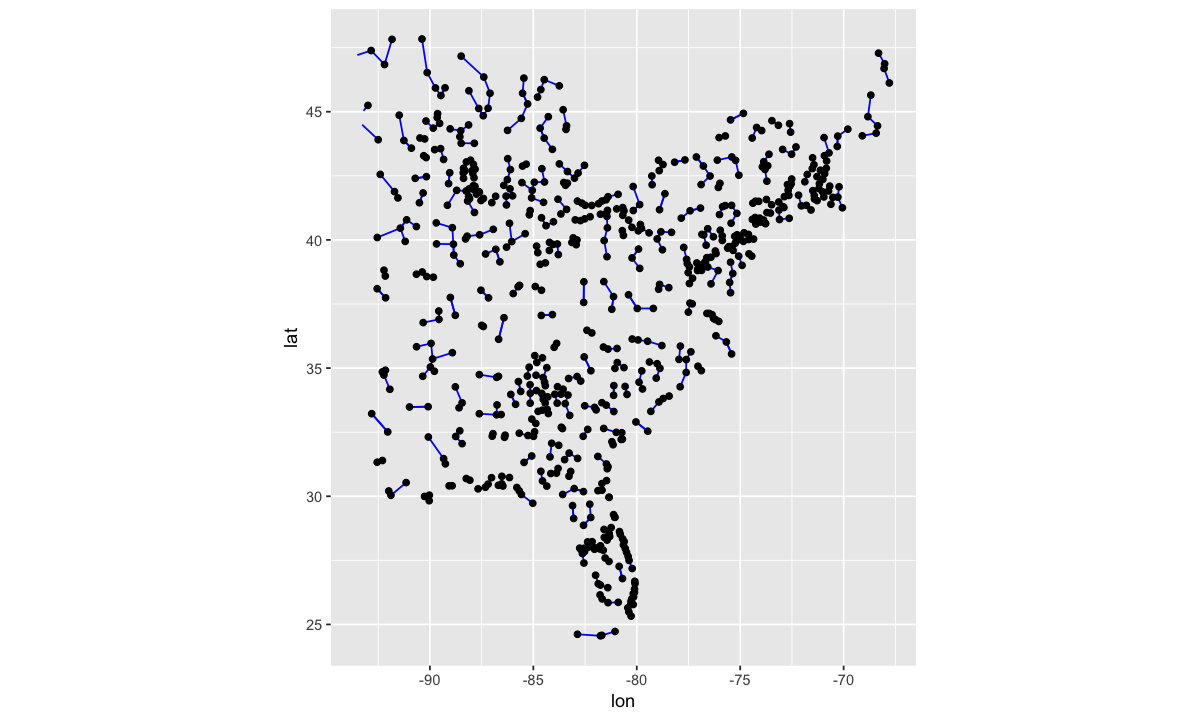

In [143]:
air_nn  %>% filter(lon > -93) %>% 
    ggplot + 
    geom_segment(aes(x = lon, y = lat, xend = lon2, yend = lat2), color="blue") +
    geom_point(aes(x = lon, y = lat)) + 
    coord_quickmap()